<a href="https://colab.research.google.com/github/Gaussiandra/NTA_Landmarks_Detection/blob/master/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Jun  2 17:34:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Импорт библиотек

In [2]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-nm_4mnzc
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-nm_4mnzc
     |████████████████████████████████| 634kB 5.1MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65038 sha256=65e6543915fdb5652ae75da1893ab0ef9f51c99838a52d9c56088f64917ba1fd
  Stored in directory: /tmp/pip-ephem-wheel-cache-ht_zf634/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=5671eeccd7757dac540a46c5b75c48359ffa03dc9188935b330af7fa4af0fcc8
  Stored in directory: /tmp/pip-ephem-wheel-cache-ht_zf634/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: album

In [0]:
import os
import cv2
import gc
import time
import random
import pickle
import albumentations as albu
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.nn import functional as fnn
from torchvision import transforms

## Параметры

In [0]:
NUM_PTS = 194
CROP_SIZE = 160
BATCH_SIZE = 64

In [0]:
SEED = 3462

random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
from google.colab import drive
drive.mount('/content/drive')

global_path = '/content/drive/My Drive/ML/NTA Landmarks Detection/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
TEST_PATH = global_path+"data/baseline_NTA/data/test/" 
TRAIN_PATH = global_path+"data/baseline_NTA/data/train/"
SUBMISSION_PATH = global_path+"data/baseline_NTA/data/train/"
LANDMARKS = global_path+"data/baseline_NTA/data/train/landmarks.csv"

SUBMISSION_HEADER = "file_name,Point_M0_X,Point_M0_Y,Point_M1_X,Point_M1_Y,Point_M2_X,Point_M2_Y,Point_M3_X,Point_M3_Y,Point_M4_X,Point_M4_Y,Point_M5_X,Point_M5_Y,Point_M6_X,Point_M6_Y,Point_M7_X,Point_M7_Y,Point_M8_X,Point_M8_Y,Point_M9_X,Point_M9_Y,Point_M10_X,Point_M10_Y,Point_M11_X,Point_M11_Y,Point_M12_X,Point_M12_Y,Point_M13_X,Point_M13_Y,Point_M14_X,Point_M14_Y,Point_M15_X,Point_M15_Y,Point_M16_X,Point_M16_Y,Point_M17_X,Point_M17_Y,Point_M18_X,Point_M18_Y,Point_M19_X,Point_M19_Y,Point_M20_X,Point_M20_Y,Point_M21_X,Point_M21_Y,Point_M22_X,Point_M22_Y,Point_M23_X,Point_M23_Y,Point_M24_X,Point_M24_Y,Point_M25_X,Point_M25_Y,Point_M26_X,Point_M26_Y,Point_M27_X,Point_M27_Y,Point_M28_X,Point_M28_Y,Point_M29_X,Point_M29_Y\n"

In [9]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.max_memory_allocated(device='cuda'))
print(torch.cuda.empty_cache())

1.5.0+cu101
10.1
7603
True
1
0
None


In [0]:
class LandmarksDataset(Dataset):
    def __init__(self, root, init_augmentations, split, train_augm=None, test_augm=None):
        assert split in ('train', 'test')

        super(LandmarksDataset, self).__init__()
        self.root = root
        self.init_augmentations = init_augmentations
        self.split = split
        self.train_augm = train_augm
        self.test_augm = test_augm

        file_name = os.path.join(root, 'test_points.csv' if split == "test" else 'landmarks.csv')
        images_root = os.path.join(root, "images")

        self.samples = []

        with open(file_name, "rt") as fp:
            for i, line in tqdm(enumerate(fp), total=len(os.listdir(images_root))):
                if i == 0:
                    continue  # skip header

                elements = line.strip().split(",")
                image_name = os.path.join(images_root, elements[0])
                cur_img = cv2.imread(image_name)
                cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)

                if split == "train":
                    landmarks = list(map(np.int16, elements[1:]))
                    landmarks = np.array(landmarks, dtype=np.int16).reshape((len(landmarks) // 2, 2))
                else:
                    landmarks = []

                augmented_data = init_augmentations(image=cur_img, keypoints=landmarks)
                cur_sample = {
                    'x_init_resolution': cur_img.shape[1],
                    'y_init_resolution': cur_img.shape[0],
                    'image': augmented_data['image'],
                    'keypoints': augmented_data['keypoints']
                }

                self.samples.append(cur_sample)

    def get_box(self, keypoints, bound=25):
        x_min = int(round(min(map(lambda x: x[0], keypoints))))
        x_max = int(round(max(map(lambda x: x[0], keypoints))))
        y_min = int(round(min(map(lambda x: x[1], keypoints))))
        y_max = int(round(max(map(lambda x: x[1], keypoints))))

        return (
            max(0, x_min-bound),
            max(0, y_min-bound),
            min(2*CROP_SIZE, x_max+bound),
            min(2*CROP_SIZE, y_max+bound)
        )
    
    def __getitem__(self, idx):
        cur_sample = dict(self.samples[idx])

        if self.split == 'train':
            augmented_data = self.train_augm(
                cropping_bbox=self.get_box(cur_sample['keypoints']),
                **cur_sample
            )
            
            cur_sample['image'] = augmented_data['image']
            cur_sample['keypoints'] = np.array(augmented_data['keypoints'])
            return cur_sample
        else:
            return self.test_augm(**cur_sample)

    def __len__(self):
        return len(self.samples)

In [0]:
keypoint_reflection_indexes = [
    [slice(0, 21), slice(40, 19, -1)],
    [slice(41, 50), slice(57, 48, -1)],
    [slice(58, 65), slice(71, 64, -1)],
    [slice(72, 79), slice(85, 78, -1)],
    [slice(86, 93), slice(99, 92, -1)],
    [slice(100, 107), slice(113, 106, -1)],
    [slice(114, 134), slice(134, 154)],
    [slice(154, 174), slice(174, 194)]
]

def reflect_keypoints(keypoints):
    new_keypoints = deepcopy(keypoints)
    for slice1, slice2 in keypoint_reflection_indexes:
        new_keypoints[slice1] = keypoints[slice2]
        new_keypoints[slice2] = keypoints[slice1]
    return new_keypoints

class CustomHorizontalFlip(albu.HorizontalFlip):
    def apply_to_keypoints(self, keypoints, **params):
        keypoints = reflect_keypoints(keypoints)
        return super().apply_to_keypoints(keypoints, **params)

init_augm = albu.Compose([
    albu.LongestMaxSize(2*CROP_SIZE),
    albu.PadIfNeeded(2*CROP_SIZE, 2*CROP_SIZE, 1),                  
], keypoint_params=albu.KeypointParams(format='xy', remove_invisible=False))

train_augm = albu.Compose([
    albu.IAAPerspective((0, 0.04), p=0.5),
    albu.RandomCropNearBBox(0.15, p=0.4),
    CustomHorizontalFlip(p=0.5),
    albu.Rotate(30, p=0.4),
    albu.Resize(CROP_SIZE, CROP_SIZE),

    albu.RGBShift(0.02, 0.02, 0.02, p=0.5),
    albu.RandomBrightnessContrast(0.1, 0.1, p=0.5),
    albu.CLAHE(2, p=0.5),
    albu.ToGray(p=0.1),
    albu.IAASharpen(p=0.5),
    albu.CoarseDropout(56, 10, 10, p=0.4),

    albu.Normalize()
], keypoint_params=albu.KeypointParams(format='xy', remove_invisible=False))

test_augm = albu.Compose([
    albu.Resize(CROP_SIZE, CROP_SIZE),
    albu.Normalize()
])

In [14]:
#whole_dataset = LandmarksDataset(os.path.join(TRAIN_PATH), init_augm, "train", train_augm=train_augm)
#test_dataset = LandmarksDataset(os.path.join(TEST_PATH), init_augm, "test", test_augm=test_augm)
#pickle.dump(whole_dataset, open(global_path+'whole_ds.pkl', 'wb'))
#pickle.dump(test_dataset, open(global_path+'test_ds.pkl', 'wb'))

In [0]:
whole_dataset = pickle.load(open(global_path+'whole_ds.pkl', 'rb'))
test_dataset = pickle.load(open(global_path+'test_ds.pkl', 'rb'))

In [0]:
whole_dataset.train_augm = train_augm
test_dataset.test_augm = test_augm

In [0]:
from torch.utils.data import random_split
train_size = int(0.9 * len(whole_dataset))
val_size = len(whole_dataset) - train_size
train_dataset, val_dataset = random_split(whole_dataset, [train_size, val_size])

train_iter = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
val_iter = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
test_iter = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)

In [0]:
def vis_points(image, points, diameter=15, rec_coords=None):
    im = image.copy()
    
    if rec_coords:
        cv2.rectangle(im, (rec_coords[0], rec_coords[1]), (rec_coords[2], rec_coords[3]),
                      (255, 0, 0), thickness=diameter)
    for i, (x, y) in enumerate(points):
        cv2.circle(im, (int(x), int(y)), diameter, (255, 0, 0), -1)
        #cv2.putText(im,
        #            str(i),
        #            (int(x), int(y)),
        #            cv2.FONT_HERSHEY_COMPLEX_SMALL, 
        #            2,
        #            (255, 0, 0),
        #            2)

    plt.figure(figsize=(8, 8))
    plt.imshow(im)

In [0]:
landmark_csv = pd.read_csv(os.path.join(TRAIN_PATH, 'landmarks.csv'), index_col='filename')

In [0]:
chf = albu.Compose([
    CustomHorizontalFlip(p=0)
], keypoint_params=albu.KeypointParams(format='xy', remove_invisible=False))

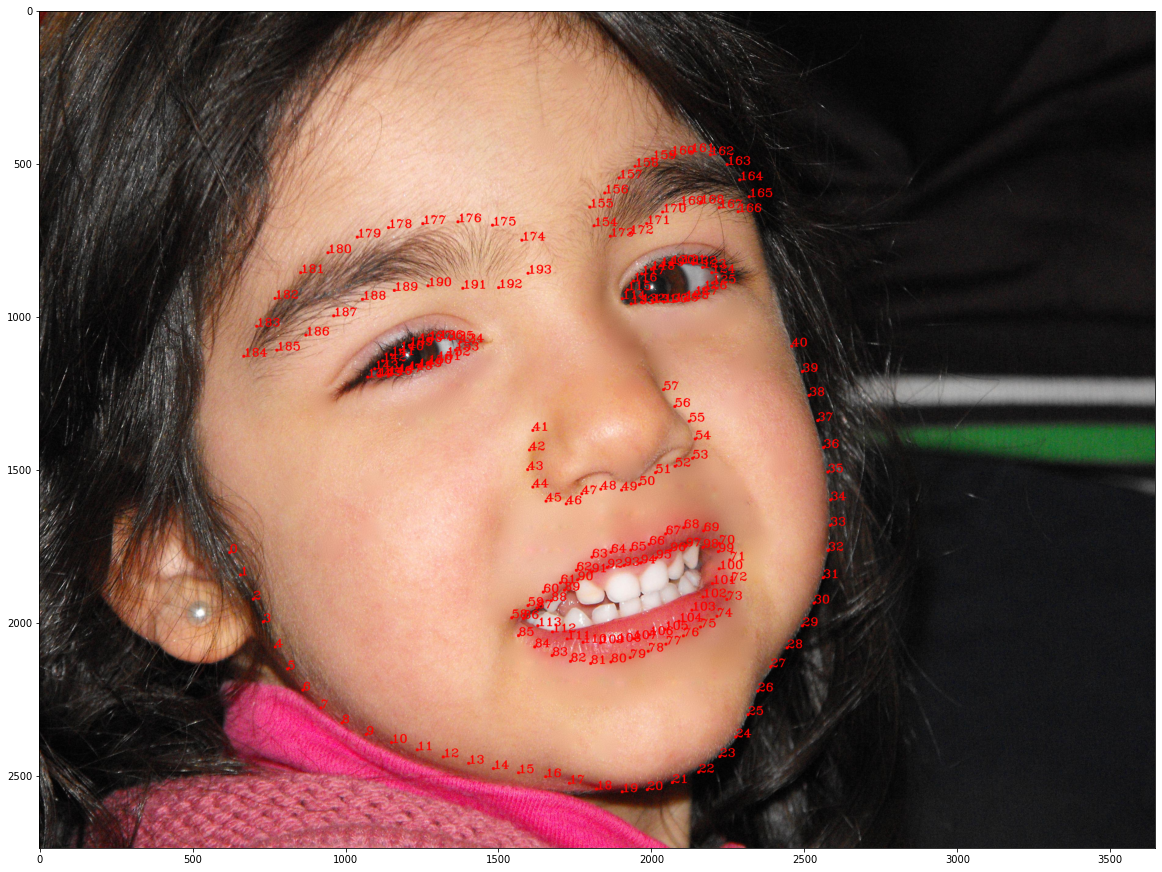

In [133]:
images_root = os.path.join(TRAIN_PATH, "images")
image_name = '2941961941_1.jpg'

cur_img = cv2.imread(os.path.join(images_root, image_name))
cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)

landmarks = list(map(np.int16, landmark_csv.loc[image_name].values))
landmarks = np.array(landmarks, dtype=np.int16).reshape((len(landmarks) // 2, 2))

augm_img = chf(image=cur_img, keypoints=landmarks)
vis_points(augm_img['image'], augm_img['keypoints'], diameter=5)
plt.show()

In [0]:
# За такой страшный хардкод сори
# Каждая точка -- начало нового удобно обратимого промежутка
critical_points = [0, 41, 58, 72, 86, 101, 114]
flip_dict = {}

for i in range(1, len(critical_points)):
    for j, point in enumerate(range(critical_points[i-1], critical_points[i])):
        flip_dict[point] = critical_points[i] - j - 1

critical_points = [114, 134, 154, 194]
for i in range(1, len(critical_points), 2):
    for j in range(critical_points[i-1], critical_points[i]):
        flip_dict[j] = flip_dict.get(j, j + 20)
        flip_dict[j + 20] = flip_dict.get(j + 20, j)
   
assert all([flip_dict[flip_dict[k]] == k for i, (k, v) in enumerate(flip_dict.items()) if i < NUM_PTS])

In [0]:
gc.collect()

866

In [14]:
!pip install facenet_pytorch

In [0]:
from facenet_pytorch import InceptionResnetV1
vggface2 = InceptionResnetV1(pretrained='vggface2')

In [237]:
cut_vggface2 = nn.Sequential(*list(vggface2.children())[:-4])
cut_vggface2

Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (1): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (2): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (5): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3,

In [295]:
model = nn.Sequential(
    cut_vggface2,
    nn.Conv2d(1792, 2*NUM_PTS, 1),
    nn.MaxPool2d(1, 1),
    nn.Flatten(),
    nn.Dropout(0.05),

    nn.Linear(2*NUM_PTS, 2*NUM_PTS),
    nn.LeakyReLU(),
    nn.Dropout(0.05),

    nn.Linear(2*NUM_PTS, 2*NUM_PTS),
    nn.LeakyReLU(),
    nn.Dropout(0.05),

    nn.Linear(2*NUM_PTS, 2*NUM_PTS),
    nn.LeakyReLU(),
    nn.Dropout(0.05),

    nn.Linear(2*NUM_PTS, 2*NUM_PTS),
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
loss_fn = fnn.mse_loss

cur_iter = 0

model(torch.randn(4, 3, 160, 160).to(device)).shape

torch.Size([4, 388])

In [0]:
class FaceDetector9000(nn.Module):
    def __init__(self, dropout_p=0.05):
        super().__init__()

        self.dropout_p = dropout_p

        self.base_model = nn.Sequential(*list(vggface2.children())[:-5])
        for param in self.base_model.parameters():
            param.requires_grad = True

        self.conv1 = nn.Conv2d(1792, 4*NUM_PTS, 3)
        self.pool1 = nn.MaxPool2d(3, 1, 1)
        self.linear1 = nn.Linear(4*NUM_PTS, 2*NUM_PTS)
        self.linear2 = nn.Linear(2*NUM_PTS, 2*NUM_PTS)
        #self.linear3 = nn.Linear(2*NUM_PTS, 2*NUM_PTS)

        self.dropout = nn.Dropout(p=dropout_p)
    
    def forward(self, x):
        x = self.base_model(x)
        x = self.dropout(x)

        x = self.conv1(x)
        x = self.pool1(x).reshape(-1, 4*NUM_PTS)
        x = self.dropout(x)

        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.linear2(x)
        return x

model = FaceDetector9000().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
loss_fn = fnn.mse_loss

cur_iter = 0

In [0]:
# Другой facenet, больше аугментаций, нормальная архитектура, статеечки, лайфхаки по аугментациям
# Работа с фото с самыми высокими ошибками, hard negatives mining?
# Клиппинг предсказанны координат
# Усреднять значения для теста на аугментации
# Усреднять веса с лучших точек
# погуглить про pseudolabeling

In [0]:
#!rm -rf '/content/drive/My Drive/ML/TG_DL/10/tensorboard/'

In [0]:
model_name = 'norm vggface2_cut-4 conv_pool_4lin'

In [300]:
last_checkpoint = torch.load(
    global_path+"norm vggface2_cut-4 conv_pool_2lin_4877.tar",
    map_location=device
)

model.load_state_dict(last_checkpoint['model'], strict=False)
#optimizer.load_state_dict(last_checkpoint['optim'])
last_checkpoint['n_iters']

4877

In [99]:
import tensorflow as tf
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
tb_path = global_path+'tensorboard/'
train_summary_writer = tf.summary.create_file_writer(tb_path+model_name+'_train')
val_summary_writer = tf.summary.create_file_writer(tb_path+model_name+'_val')

In [322]:
%tensorboard --logdir '/content/drive/My Drive/ML/NTA Landmarks Detection/tensorboard/'

<IPython.core.display.Javascript object>

In [0]:
for e in range(35):
    for batch in tqdm(train_iter, desc=str(f'{e}_{cur_iter}')):
        model.train()
        optimizer.zero_grad()

        images = batch['image'].permute([0, 3, 1, 2]).to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch['keypoints'].reshape(-1, 2 * NUM_PTS).to(torch.float32).to(device)  # B x (2 * NUM_PTS)

        pred_landmarks = model(images)  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")

        with train_summary_writer.as_default():
            tf.summary.scalar('loss', loss.item(), step=cur_iter)

        loss.backward()
        optimizer.step()

        if cur_iter % 10 == 0:
            model.eval()

            for batch in val_iter:
                images = batch['image'].permute([0, 3, 1, 2]).to(device)
                landmarks =  batch['keypoints'].reshape(-1, 2 * NUM_PTS).to(torch.float32).to(device)

                with torch.no_grad():
                    pred_landmarks = model(images)
                loss = loss_fn(pred_landmarks, landmarks, reduction="mean")

                with val_summary_writer.as_default():
                    tf.summary.scalar('loss', loss.item(), step=cur_iter)

                break # Написать по-нормальному

        cur_iter += 1

In [0]:
save_path = f'{global_path}{model_name}_{cur_iter}.tar'
assert not os.path.exists(save_path)
torch.save({
            'model': model.state_dict(),
            'optim': optimizer.state_dict(),
            'n_iters': cur_iter
        }, save_path)      

In [315]:
losses = []

val_iter = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
model.eval()
for batch in val_iter:
    images = batch['image'].permute([0, 3, 1, 2]).to(device)
    landmarks = batch['keypoints'].reshape(-1, 2 * NUM_PTS).to(torch.float32).to(device)

    with torch.no_grad():
        pred_landmarks = model(images)
    loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
    losses.append(loss.item())
print(np.mean(losses), np.std(losses))

7.907806396484375 1.6639794753397346


In [0]:
def shift_augm_landmark(init_resolution, landmarks):
    points = torch.tensor(landmarks) 

    scale_factor = max(init_resolution) / CROP_SIZE
    x_margin = (CROP_SIZE - init_resolution[0] / scale_factor) / 2
    y_margin = (CROP_SIZE - init_resolution[1] / scale_factor) / 2
    margin_pair = np.array([x_margin, y_margin])

    handle_pair = lambda x: (x - margin_pair) * scale_factor
    return list(map(handle_pair, points))
    
def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    
    cur_str = 0
    for i, batch in enumerate(tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch['image'].permute([0, 3, 1, 2]).to(device) 

        with torch.no_grad():
            pred_landmarks = model(images).cpu().numpy()  # B x NUM_PTS x 2

        for j in range(len(batch['x_init_resolution'])):
            hz = shift_augm_landmark((batch['x_init_resolution'][j], batch['y_init_resolution'][j]), pred_landmarks[j].reshape(NUM_PTS, 2))
            hz = np.array(list(map(lambda x: np.array(x), hz)))

            predictions[cur_str] = hz
            cur_str += 1

    return predictions

def create_submission(path_to_data, test_predictions, path_to_submission_file):
    test_dir = os.path.join(path_to_data)

    output_file = path_to_submission_file
    wf = open(output_file, 'w')
    wf.write(SUBMISSION_HEADER)

    mapping_path = os.path.join(test_dir, 'test_points.csv')
    mapping = pd.read_csv(mapping_path, delimiter=',')
    
    for i, row in mapping.iterrows():   
        file_name = row[0]

        point_index_list = np.array(eval(row[1]))
        points_for_image = test_predictions[i]
        needed_points = points_for_image[point_index_list].astype(np.int)
        wf.write(file_name + ',' + ','.join(map(str, needed_points.reshape(2 * len(point_index_list)))) + '\n')

In [316]:
test_iter = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)
test_predictions = predict(model, test_iter, device)

In [0]:
create_submission(TEST_PATH, test_predictions, "submit.csv")

---

In [53]:
np.size(test_predictions) - np.count_nonzero(test_predictions)

0

In [0]:
def get_orig_img(path, split, index):
    root = path
    file_name = os.path.join(root, 'test_points.csv' if split == "test" else 'landmarks.csv')
    images_root = os.path.join(root, "images")

    with open(file_name, "rt") as fp:
        for i, line in tqdm(enumerate(fp)):
            if i != index+1:
                continue

            elements = line.strip().split(",")
            image_name = os.path.join(images_root, elements[0])
            cur_img = cv2.imread(image_name)
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)

            return cur_img

In [0]:
def coords_from_sumb_file(path, index):
    with open(path, "rt") as fp:
        for i, line in tqdm(enumerate(fp)):
            if i != index+1:
                continue

            elements = line.strip().split(",")
            return np.array(list(map(int, elements[1:])))

In [0]:
def landmarks2pairs(points):
    x_coords = np.array(points[::2], dtype=np.uint8)
    y_coords = np.array(points[1::2], dtype=np.uint8)

    return list(zip(x_coords, y_coords))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


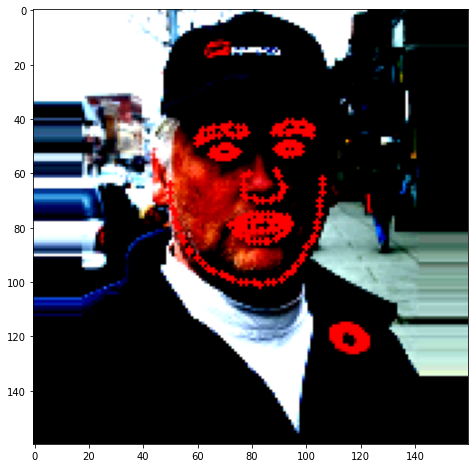

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


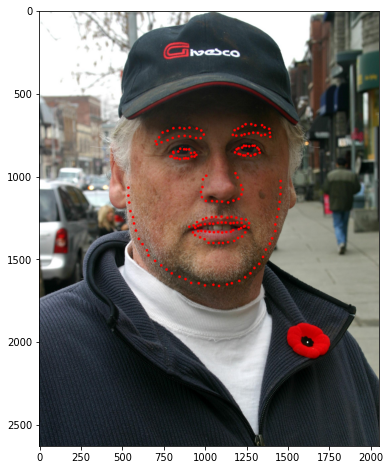

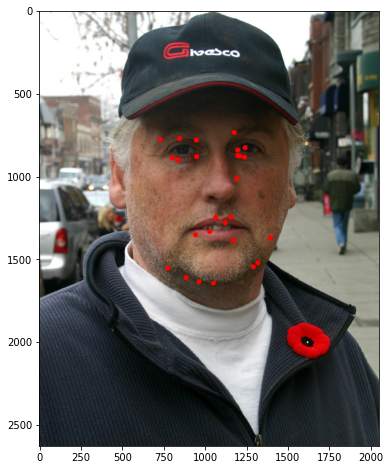

In [321]:
cur_img, cur_predictions, id = 0, 0, np.random.randint(64)

model.eval()
test_iter = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)
for i, data in enumerate(test_iter):
    cur_img = data['image'].permute([0, 3, 1, 2])[id].unsqueeze(dim=0).to(device)
    cur_predictions = model(cur_img).cpu().detach()
    break

vis_points(test_dataset[id]['image'], landmarks2pairs(cur_predictions[0]), diameter=1)
plt.show()

cur_orig_img = get_orig_img(TEST_PATH, 'test', id)
shifted_preds = shift_augm_landmark((test_dataset[id]['x_init_resolution'], test_dataset[id]['y_init_resolution']), cur_predictions[0].reshape(194, 2))
vis_points(cur_orig_img, shifted_preds, 8)
plt.show()

vis_points(cur_orig_img, coords_from_sumb_file("submit.csv", id).reshape(-1, 2))

---